In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

MODEL_NAME = 'funcionavai'

headers = ['step','reward','timestamps']
df_model = pd.read_csv(f'results/{MODEL_NAME}.csv', names=headers)
# remove the first row
df_model = df_model.iloc[1:]

df_model.head()

,step,reward,timestamps
1,1203,-4.181600,33.367831
2,2406,-3.351558,61.953562
3,3609,-93.126785,90.290424
4,4812,-75.823138,119.044865
5,6015,-95.768831,147.794793


In [29]:
# construindo a paleta de cores:
maingreen = '#8fd14f'
black = '#1b1b1b'
white = '#f3f3f3'
secondarygreen = '#bad4bd'
sns.set_palette(sns.color_palette([maingreen, black, white, secondarygreen]))

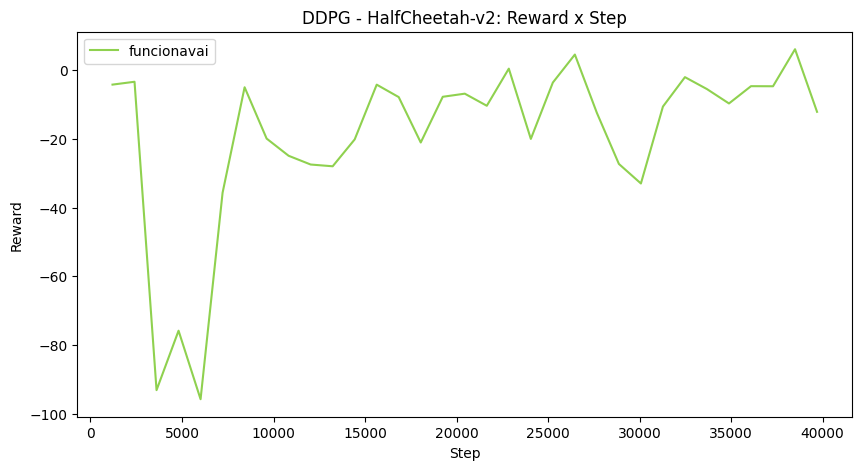

In [30]:
# plotando o gráfico
plt.figure(figsize=(10,5))
plt.plot(df_model['step'], df_model['reward'], label=MODEL_NAME)
plt.xlabel('Step')
plt.ylabel('Reward')
plt.legend()
plt.title('DDPG - HalfCheetah-v2: Reward x Step')

plt.show()

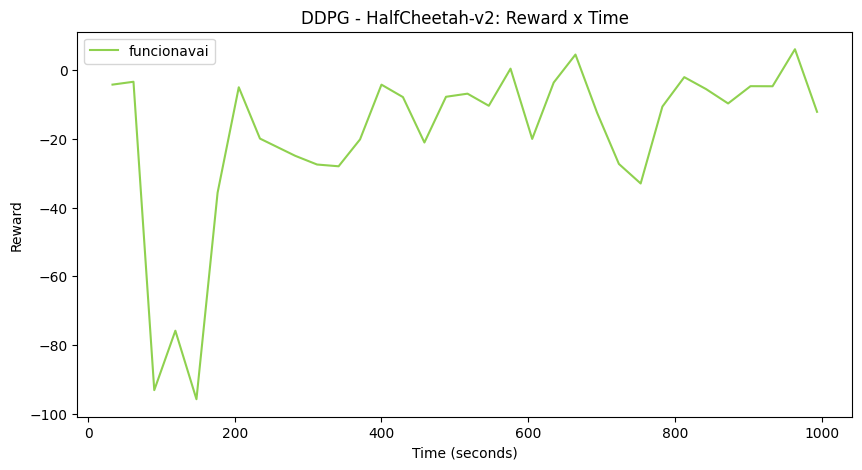

In [31]:
# fazendo o plot para o tempo
plt.figure(figsize=(10,5))
plt.plot(df_model['timestamps'], df_model['reward'], label=MODEL_NAME)
plt.xlabel('Time (seconds)')
plt.ylabel('Reward')
plt.legend()
plt.title('DDPG - HalfCheetah-v2: Reward x Time')
plt.show()

In [39]:
# carregando todos os csvs na pasta results
import os
import pandas as pd

# lista com todos os arquivos csv na pasta results
csvs = [x for x in os.listdir('results') if x.endswith('.csv') and not x.startswith('test_')]

# carregando todos os csvs em um dataframe, e fazendo uma coluna name com o nome do arquivo
df = pd.concat([pd.read_csv(f'results/{csv}', names=['step','reward','timestamps']).assign(name=csv[:-4]) for csv in csvs])
blackList = ["BestCheetah"]
# df = df[~df['name'].isin(blackList)]

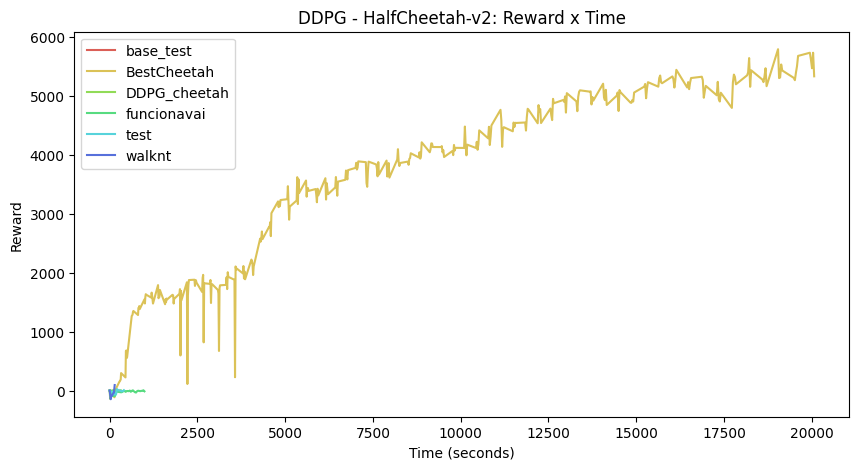

In [40]:
# fazendo o plot para o tempo, mas cada modelo em uma linha
plt.figure(figsize=(10,5))
# mudando a paleta de cores para uma com mais cores
sns.set_palette(sns.color_palette("hls", 8))
sns.lineplot(x='timestamps', y='reward', hue='name', data=df)
plt.xlabel('Time (seconds)')
plt.ylabel('Reward')
plt.legend()
plt.title('DDPG - HalfCheetah-v2: Reward x Time')
plt.show()

In [34]:
import gym
from DDPG import DDPG
import torch
import numpy as np
import time

batch_size = 256
STEPS_PER_EPISODE = 1000
tests = 10
REALTIME_RENDER = False 
RENDER_VIDEO = True # não funciona caso REALTIME_RENDER = True.

def recordEpsReward(env, model, save_path = None):
    df = pd.DataFrame(columns=['step','reward','timestamps'])
    start_time = time.time()
    print()
    render = not REALTIME_RENDER and RENDER_VIDEO and save_path is not None
    if render:
        rec = gym.wrappers.monitoring.video_recorder.VideoRecorder(env, save_path)
    state = env.reset()[0]
    r = 0
    step = 0
    while True:
        action = model.predict(np.expand_dims(state, axis=0))
        if render:
            rec.capture_frame()
        state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated or step >= STEPS_PER_EPISODE
        r += reward
        df = pd.concat([df, pd.DataFrame([[step, reward, time.time() - start_time]], columns=['step','reward','timestamps'])])
        step += 1
        if done:
            if render:
                rec.close()
            print("Reward at termination: {}".format(r))
            print("Avg Reward: {}".format(r/step))
            return df

In [35]:
print("Using Test Mode: {} iterations of testing on HalfCheetah-v2".format(tests))
print("Model: {}".format(MODEL_NAME))
print("Realtime Render: {}".format(REALTIME_RENDER))
print("Render Video: {}".format(RENDER_VIDEO and not REALTIME_RENDER))
print("Cuda available: {}".format(torch.cuda.is_available()))
if torch.cuda.is_available():
    print("Device Count: {}".format(torch.cuda.device(0)))
    print("Device Name (first): {}".format(torch.cuda.get_device_name(0)))

if REALTIME_RENDER:
    env = gym.make('HalfCheetah-v2', render_mode="human")
else:
    env = gym.make('HalfCheetah-v2', render_mode="rgb_array") 

action_space = env.action_space.shape[0]
state_space = env.observation_space.shape[0] 
print("Action space: {}, State space: {}".format(action_space, state_space))

model = DDPG(state_space, action_space)
try:
    model.load(f'models/{MODEL_NAME}')
except:
    print(f"Err: No model found with this naming, please train a model with this name with ´python train.py --model {MODEL_NAME}´, or put a model with this name in the models folder")

render_video = RENDER_VIDEO and not REALTIME_RENDER


Using Test Mode: 10 iterations of testing on HalfCheetah-v2
Model: funcionavai
Realtime Render: False
Render Video: True
Cuda available: True
Device Count: <torch.cuda.device object at 0x7fd870644460>
Device Name (first): NVIDIA GeForce GTX 1650
Action space: 6, State space: 17


/home/treuke/.local/lib/python3.8/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment HalfCheetah-v2 is out of date. You should consider upgrading to version `v4`.
  logger.warn(
/home/treuke/.local/lib/python3.8/site-packages/gym/envs/mujoco/mujoco_env.py:190: UserWarning: WARN: This version of the mujoco environments depends on the mujoco-py bindings, which are no longer maintained and may stop working. Please upgrade to the v4 versions of the environments (which depend on the mujoco python bindings instead), unless you are trying to precisely replicate previous works).
  logger.warn(


Model Weights Loaded!


In [36]:
start_time = time.time()
df_rewards = pd.DataFrame(columns=['step','reward','timestamps','test'])
if(REALTIME_RENDER):
    env.reset()
    env.render()
for i in range(tests):
    print("Test {}".format(i+1))
    if i == tests-1 and render_video:
        reward = recordEpsReward(env, model, f'vid/test_{MODEL_NAME}.mp4')
    else:
        reward = recordEpsReward(env, model)
    reward['test'] = i+1
    df_rewards = pd.concat([df_rewards, reward], ignore_index=True)

df_rewards.to_csv(f'results/test_rewards{MODEL_NAME}.csv', index=False)
env.reset()
env.close()

time_passed = (time.time() - start_time) / 3600
minutes = (time_passed - int(time_passed)) * 60
time_passed = "{:02.0f}:{:02.0f}".format(int(time_passed), int(minutes))
print("Total Runtime (hours): {}   \t\t\t\t\t\t\t\t\t ".format(time_passed))

Test 1



/home/treuke/.local/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Reward at termination: -3.519730876076173
Avg Reward: -0.003519730876076173
Test 2

Reward at termination: -6.572439491820972
Avg Reward: -0.006572439491820971
Test 3

Reward at termination: -9.573218972261639
Avg Reward: -0.009573218972261639
Test 4

Reward at termination: -11.708577417851329
Avg Reward: -0.01170857741785133
Test 5

Reward at termination: -11.049206976978343
Avg Reward: -0.011049206976978343
Test 6

Reward at termination: -9.90696758658004
Avg Reward: -0.009906967586580039
Test 7

Reward at termination: -12.318068426583087
Avg Reward: -0.012318068426583088
Test 8

Reward at termination: -10.162512388441025
Avg Reward: -0.010162512388441024
Test 9

Reward at termination: -9.25774786716925
Avg Reward: -0.00925774786716925
Test 10

Moviepy - Building video vid/test_funcionavai.mp4.
Moviepy - Writing video vid/test_funcionavai.mp4



Moviepy - Done !
Moviepy - video ready vid/test_funcionavai.mp4
Reward at termination: -9.368987994242213
Avg Reward: -0.009368987994242213
Total Runtime (hours): 00:00   									 


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


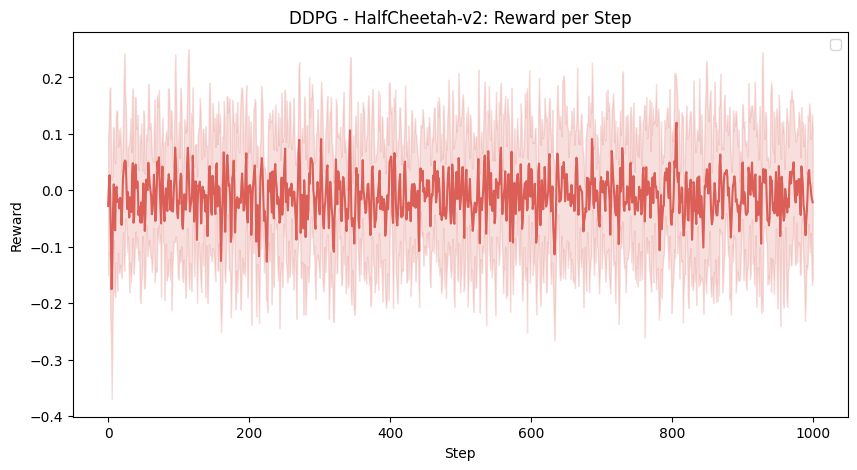

In [37]:
# agora temos df_rewards com os diversos valores diferentes de reward para cada step, vamos plotar a média deles como uma linha e a variação como uma área

# plotando o gráfico
plt.figure(figsize=(10,5))
sns.lineplot(x='step', y='reward', data=df_rewards, errorbar='sd')
plt.xlabel('Step')
plt.ylabel('Reward')
plt.legend()
plt.title('DDPG - HalfCheetah-v2: Reward per Step')
plt.show()

In [38]:
# print loaded model info (params)
print(model.actor)
print(model.critic)

Actor(
  (fc1): Linear(in_features=17, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=400, bias=True)
  (fc4): Linear(in_features=400, out_features=6, bias=True)
  (b1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (b2): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (b3): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Critic(
  (fc1): Linear(in_features=17, out_features=128, bias=True)
  (fcA1): Linear(in_features=6, out_features=256, bias=True)
  (fcS1): Linear(in_features=128, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=400, bias=True)
  (fc4): Linear(in_features=400, out_features=1, bias=True)
  (b1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (b2): Batch